In [95]:
import pickle
import json
import numpy as np
from scipy import interpolate
from sklearn.manifold import TSNE
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import rc
rc('text', usetex=True)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
# sns.set_context("paper")
sns.set()
sns.set_context('talk')
import pandas as pd 
from scipy.stats import entropy
from scipy.interpolate import spline
from  matplotlib.gridspec import GridSpecFromSubplotSpec as gsub
from  matplotlib.gridspec import GridSpec as gr

%matplotlib inline

In [184]:
baseline = pickle.load(open('../Results/baseline_track.tr', 'rb'))
topdown = pickle.load(open('../Results/topdown_resnet152_msc_track.tr', 'rb'))
word_idf_a09 = pickle.load(open('../Results/word2_tword015_CocoGlove_idf_bis_a09_track.tr', 'rb'))
word_idf_a09_dir = pickle.load(open('../Results/word2_tword015_CocoGlove_idf_bis_a09_track_dirac.tr', 'rb'))
word_a08 = pickle.load(open('../Results/word2_tword015_coco_a08_showtell_resnet50_track.tr', 'rb'))
topdown_a03 = pickle.load(open('../Results/word2_coco_tword017_a03_topdown_resnet152_msc_track.tr', 'rb'))
fn_topdown_a03 = pickle.load(open('../Results/fncnn6_word2_coco_tword017_a03_topdown_resnet152_msc_track.tr', 'rb'))
topdown_a09= pickle.load(open('../Results/word2_coco_tword009_a09_topdown_resnet152_msc_track.tr', 'rb'))
fn_topdown_a03_dir = pickle.load(open('../Results/fncnn6_word2_coco_tword017_a03_topdown_resnet152_msc_track_dirac.tr', 'rb'))
topdown_a09_dir = pickle.load(open('../Results/word2_coco_tword009_a09_topdown_resnet152_msc_track_dirac.tr', 'rb'))

In [173]:
def plot_distribs(stats, out, nim=3, th=1e-7):
    model = stats["probas"][0]
    reward  = stats["rewards"][0]
    sns.set()
    N , S, V = model.shape
    S = min(S, 9)
    N = min(N, nim)
    colors = sns.color_palette("Paired", 2*S)
    fig = plt.figure(figsize=(14, 7*N))
    outer = gr(N, 1, wspace=0, hspace=0.05)
    for n in range(N):
        en = 0
        kl = 0
        inner = gsub(S, 1,
                     subplot_spec=outer[n],
                     wspace=0, hspace=0.2)
        maxv = np.max([np.max(model[n]), np.max(reward[n])])
        for c in range(S):
            ax = plt.Subplot(fig, inner[c])
            # indices = np.arange(len(model[0, 0]))
            indices = np.array([x for x in range(len(model[0, 0])) if model[n,c,x] > th or reward[n,c,x] > th])
            ax.plot(indices, model[n, c, indices], c='r', alpha=.5, lw=.8, label='$p_\\theta$')
            ax.plot(indices, reward[n, c, indices], c='b', alpha=.5, lw=.8, label="reward")
#             print('ind:', len(indices))
#             print('min/max reward', np.min(reward[n, c, indices]), np.max(reward[n, c, indices]))
#             print('min/max ptheta', np.min(model[n, c, indices]), np.max(model[n, c, indices]))
            # ax.bar(10*indices, model[n, c, indices], ec=colors[2*c], fc=colors[2*c], alpha=1, width=5, align="edge")
            # ax.bar(10*indices +5, reward[n, c, indices], ec=colors[2*c+1], fc=colors[2*c+1], alpha=1, width=5, align='edge')
            kl  = entropy(reward[n, c, :], model[n, c, :])
            en  = entropy(model[n, c, :])
            ax.text(20,3*maxv/4,'t = %d, KL=%.2f, $H(p_\\theta$)=%.2f' % (c, kl, en), fontsize=7)
            ax.set_xlim([1,V])
            ax.set_ylim([0,maxv])
            if not c:
                ax.legend(loc=4)
            if not c == S-1:
                ax.set_xticks([])
            ax.grid('off')
            fig.add_subplot(ax)    
    plt.savefig('../figures/%s_distrib.png' % out,
                dpi=300, bbox_inches='tight')

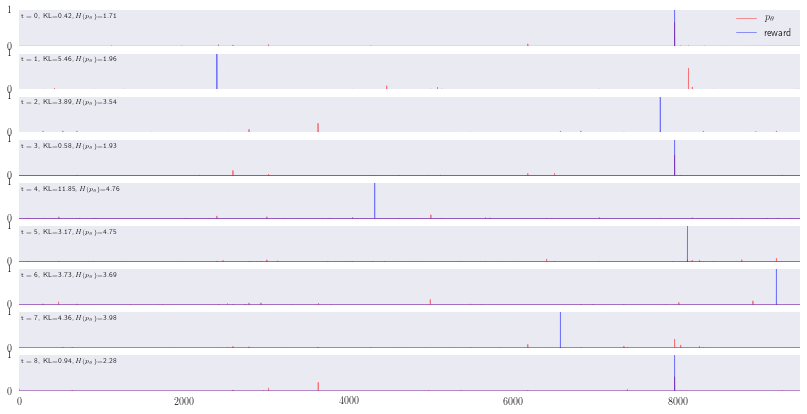

In [174]:
plot_distribs(baseline, 'ml_showtell', nim=1, th=1e-9)

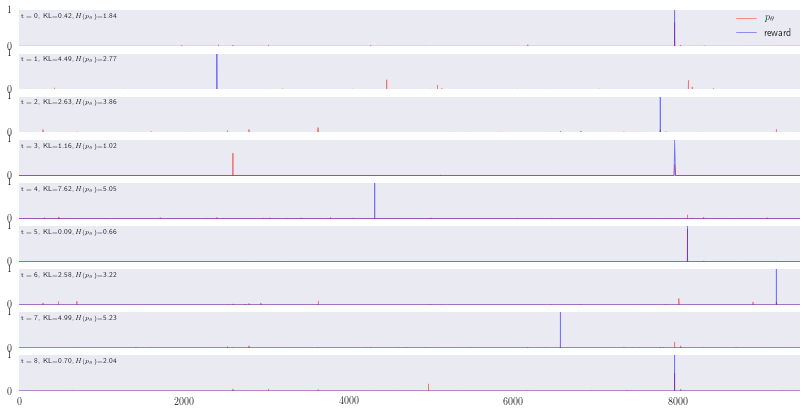

In [183]:
plot_distribs(topdown, 'ml_topdown', nim=1, th=1e-9)

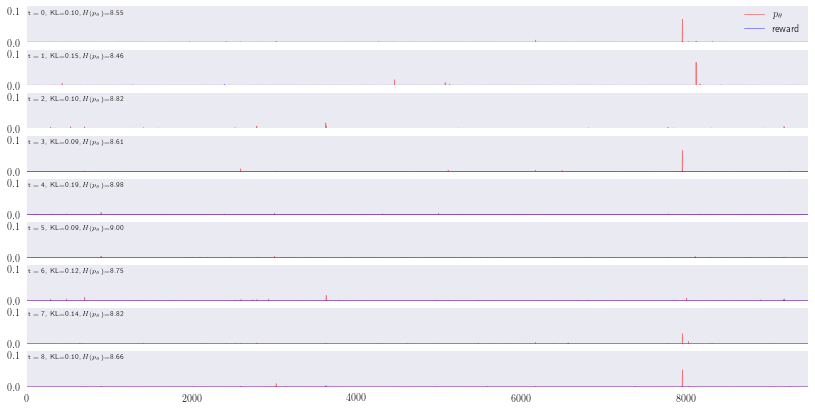

In [175]:
plot_distribs(word_idf_a09, 'word_t015_idf_a09_showtell', nim=1, th=1e-4)

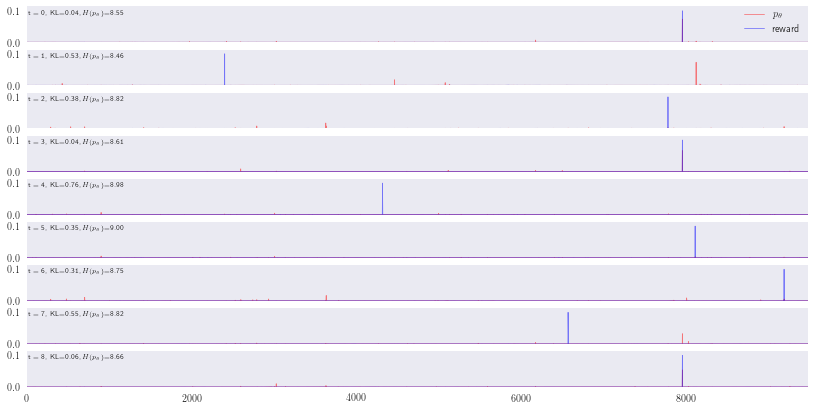

In [185]:
plot_distribs(word_idf_a09_dir, 'word_t015_idf_a09_showtell_dir', nim=1, th=1e-4)

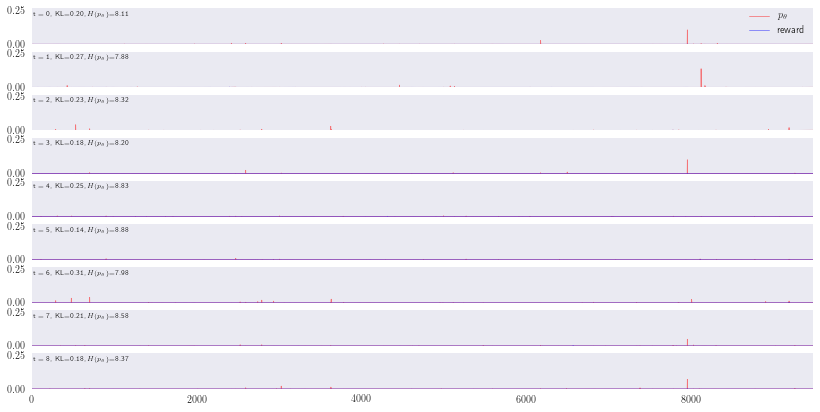

In [176]:
plot_distribs(word_a08, 'word_t015_a08_showtell', nim=1, th=1e-4)

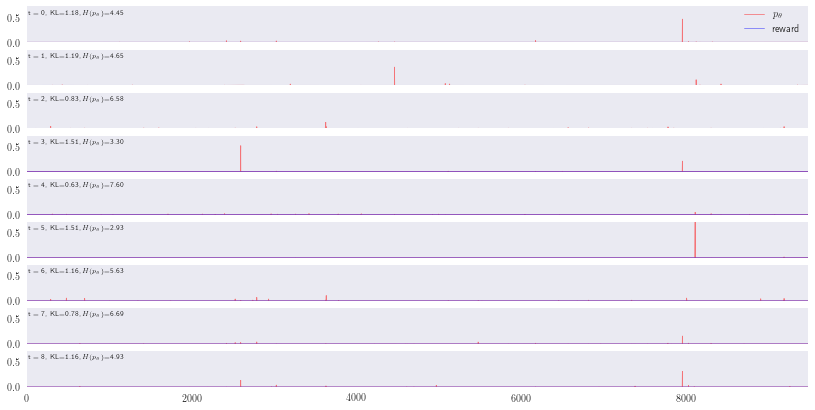

In [177]:
plot_distribs(topdown_a03, 'word_t017_a03_topdown', nim=1, th=1e-4)

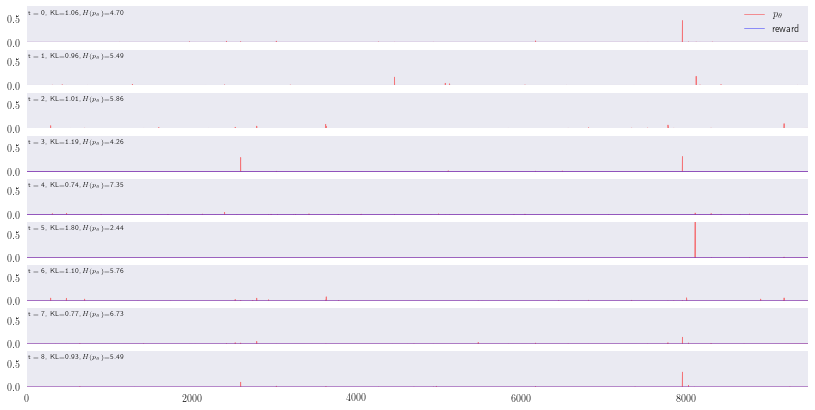

In [178]:
plot_distribs(fn_topdown_a03, 'fn_word_t017_a03_topdown', nim=1, th=1e-4)

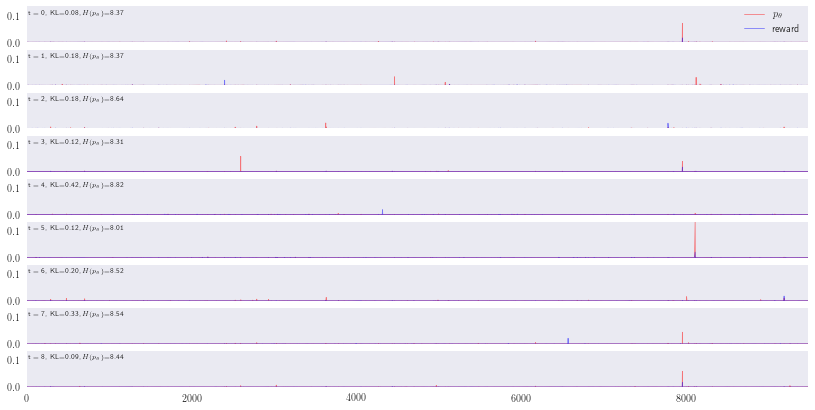

In [179]:
plot_distribs(topdown_a09, 'word_t009_a09_topdown', nim=1, th=1e-4)

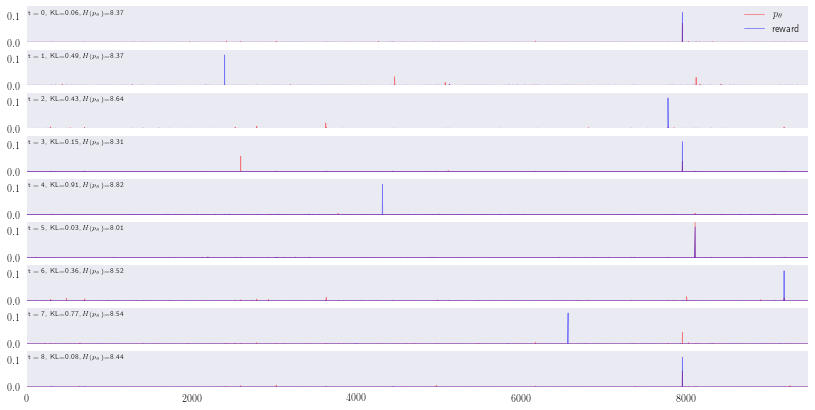

In [180]:
plot_distribs(topdown_a09_dir, 'word_t009_a09_dir_topdown', nim=1, th=1e-4)

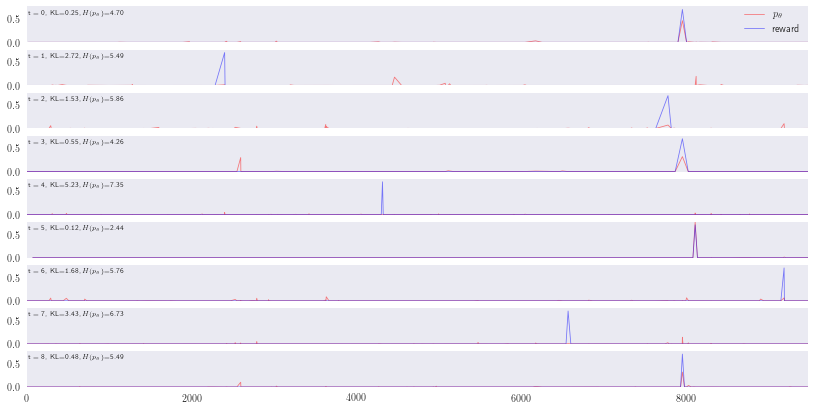

In [181]:
plot_distribs(fn_topdown_a03_dir, 'fn_word_t017_a03_dir_topdown', nim=1, th=1e-4)

In [ ]:
# heatmap:
def plot_distribs_mat(stats, out, nim=3, th=1e-5):
    model = stats["probas"][0]
    reward  = stats["rewards"][0]
    sns.set()
    N , S, V = model.shape
    S = min(S, 9)
    N = min(N, nim)
#     colors = sns.color_palette("Set2", S)
    colors = sns.hls_palette(S, l=.3, s=.8)
    f, axs = plt.subplots(2*N, 1, figsize=(28, 2 * N), sharex=True)
    for n in range(N):
        kl = 0
        en = 0
        for c in range(1, S):
            kl  += entropy(reward[n, c, :], model[n, c, :])
            en  += entropy(model[n, c, :])
        kl /= (S-1)
        en /= (S-1)
        print('min / max ptheta:', np.min(model[n, 1:S]), np.max(model[n, 1:S]))
        sns.heatmap(model[n, 1:S], annot=False, cmap="YlGnBu",
                    vmax=1e-2, vmin=th, ax=axs[2*n])
        print('min / max reward:', np.min(reward[n, 1:S]), np.max(reward[n, 1:S]))
        sns.heatmap(reward[n, 1:S], annot=False, cmap="YlGnBu",
                    ax=axs[2*n+1])
        axs[2*n].set_title('mean KL=%.2f, mean $H(p_\\theta$)=%.2f' % (kl, en))
    # plt.legend(ncol=4)
    plt.savefig('../figures/%s_distrib_mat.png' % out,
                dpi=300, bbox_inches='tight')
    
plot_distribs_mat(baseline, 'ml_showtell', nim=1, th=1e-4)